In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
%matplotlib inline

In [2]:
# Read the dataset into a data frame
df = pd.read_excel('nyc_crime2013.xls', skiprows=4)
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [3]:
# Create a data frame with only the features of interest
df.rename(columns={'Property\ncrime': 'PropertyCrime', 'Murder and\nnonnegligent\nmanslaughter': 'Murder',
                     'Rape\n(legacy\ndefinition)2': 'Rape', 'Aggravated\nassault': 'AggravatedAssault', 
                   'Violent\ncrime': 'ViolentCrime'}, inplace=True)
pc_df = df[['City', 'Population', 'ViolentCrime', 'Murder', 'Rape', 'Robbery', 'AggravatedAssault',
            'PropertyCrime']].copy()

pc_df.head()

,City,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime
0,Adams Village,1861.0,0.0,0.0,0.0,0.0,0.0,12.0
1,Addison Town and Village,2577.0,3.0,0.0,0.0,0.0,3.0,24.0
2,Akron Village,2846.0,3.0,0.0,0.0,0.0,3.0,16.0
3,Albany,97956.0,791.0,8.0,30.0,227.0,526.0,4090.0
4,Albion Village,6388.0,23.0,0.0,3.0,4.0,16.0,223.0


In [4]:
# Determine if there are null values
pc_df.isna().sum()

City                 0
Population           3
ViolentCrime         3
Murder               3
Rape                 3
Robbery              3
AggravatedAssault    3
PropertyCrime        3
dtype: int64

In [5]:
# Drop the information rows at the end of the dataset
pc_df.dropna(how='any', inplace=True)
pc_df.describe()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime
count,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,4.003763e+04,201.594828,1.566092,5.864943,72.902299,121.261494,792.606322
std,4.500374e+05,2815.268504,18.303673,60.425452,1031.032873,1706.131730,7659.724746
min,5.260000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.003000e+03,2.000000,0.000000,0.000000,0.000000,1.000000,40.500000
50%,7.233500e+03,6.000000,0.000000,0.000000,1.000000,4.000000,112.500000
75%,1.842750e+04,22.000000,0.000000,2.000000,5.000000,14.000000,341.000000
max,8.396126e+06,52384.000000,335.000000,1112.000000,19170.000000,31767.000000,141971.000000


In [6]:
# Find the amomalous robbery cities
robbery_anomaly = pc_df['Robbery'].mean() + (2 * np.std(pc_df['Robbery'])) 
pc_df.loc[pc_df['Robbery'] > robbery_anomaly]

,City,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime
216,New York,8396126.0,52384.0,335.0,1112.0,19170.0,31767.0,141971.0


In [7]:
# Find the anomalous murder cities
m_anomaly = pc_df['Murder'].mean() + (2 * np.std(pc_df['Murder'])) 
big_cities = pc_df.loc[pc_df['Murder'] > m_anomaly]

In [8]:
# Drop the anomalous big cities because of the outsized effect they would have on the model
# These big cities might be better suited with a comparison of other large urban areas across the nation
pc_df.drop(big_cities.index, inplace=True)
pc_df.describe()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,14688.750725,35.985507,0.350725,2.005797,11.478261,22.150725,322.649275
std,21318.571420,118.712460,1.587160,5.788920,41.615561,71.519231,612.050221
min,526.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2985.000000,2.000000,0.000000,0.000000,0.000000,1.000000,39.000000
50%,7112.000000,6.000000,0.000000,0.000000,1.000000,4.000000,112.000000
75%,17965.000000,21.000000,0.000000,2.000000,5.000000,14.000000,337.000000
max,199134.000000,1192.000000,21.000000,75.000000,400.000000,696.000000,6473.000000


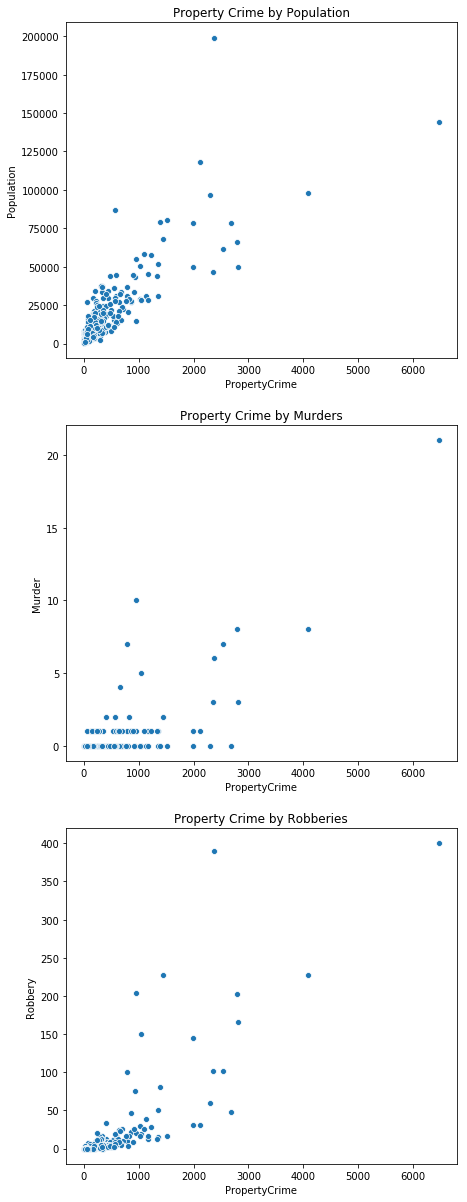

In [9]:
plt.figure(figsize=(7, 21))

plt.subplot(3,1,1)
sns.scatterplot(pc_df['PropertyCrime'], pc_df['Population'])
plt.title('Property Crime by Population')

plt.subplot(3,1,2)
sns.scatterplot(pc_df['PropertyCrime'], pc_df['Murder'])
plt.title('Property Crime by Murders')

plt.subplot(3,1,3)
sns.scatterplot(pc_df['PropertyCrime'], pc_df['Robbery'])
plt.title('Property Crime by Robberies')
plt.show()

In [10]:
#Create features for population squared and for the categorical version of murder and other violent crimes 
pc_df['Murder'] = pc_df['Murder'].apply(lambda x:  1 if x>0 else 0)
pc_df['PopSq'] = pc_df['Population'].apply(lambda x: x**2)
pc_df['OtherViolentCrime'] = pc_df['ViolentCrime'] - (pc_df['Murder'] + pc_df['Rape'] +
                                                     pc_df['Robbery'] + pc_df['AggravatedAssault'])
pc_df.head()

,City,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,PopSq,OtherViolentCrime
0,Adams Village,1861.0,0.0,0,0.0,0.0,0.0,12.0,3.463321e+06,0.0
1,Addison Town and Village,2577.0,3.0,0,0.0,0.0,3.0,24.0,6.640929e+06,0.0
2,Akron Village,2846.0,3.0,0,0.0,0.0,3.0,16.0,8.099716e+06,0.0
3,Albany,97956.0,791.0,1,30.0,227.0,526.0,4090.0,9.595378e+09,7.0
4,Albion Village,6388.0,23.0,0,3.0,4.0,16.0,223.0,4.080654e+07,0.0


In [11]:
# Build regression model 
from sklearn.linear_model import LinearRegression
X = pc_df[['Murder', 'Population', 'Robbery']]
Y = pc_df['PropertyCrime']
regr = LinearRegression().fit(X, Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [9.71900745e+01 1.45719088e-02 5.84871299e+00]

Intercept: 
 28.51440915593298

R-squared:
0.7727863436737816


##  Feature Engineering and Model Performance
The features requested in the previous exercises included some outliers. I found the outliers by taking anything greater than 2 standard deviations from the mean in murders and robberies and dropped them. The model would lose predictive capability for smaller cities if the dense urban centers were included in the data. The relationship between each of the features and the outcome variable was not linear, so I performed some transformations. I looked at the plots and applied a square root to the to the robberies to get closer to linear, but I did not see any way of getting the murders relationship to property crime close to linear, so I used the suggestion of one-hot encoding them. 

The R-Squared scored seemed to be relatively high, but the predictions were way off. This could be attributed to the fact that there is not a linear relationship between the way crime grows from small cities to large cities. There is also a factor of density missing, which I think would help explain the property crime even better. Socio-economic distribution in the city could also be more predictive of property crime.

Using just the data set given, the model is more closely predictive when set up per the previous exercise (murder and robbery one-hot encoded and population squared added as a feature). It might be worth trimming the tails even a bit more than just those greater than 2 standard deviations from the mean. I could also try normalizing the outcome variable.

## Model Validation and Iteration
It's time to T-test the features in this model and try to get some features that are more descriptive of variance in the outcome variable.

In [12]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [13]:
linear_formula1 = 'PropertyCrime ~ Population+Robbery+Murder'
lm1 = smf.ols(formula=linear_formula1, data=pc_df).fit()
print('P-Values:\n{}'.format(lm1.pvalues))
print('Model 1 R-Squared: {:2f}'.format(lm1.rsquared))

P-Values:
Intercept     1.584022e-01
Population    8.643491e-30
Robbery       2.176504e-20
Murder        7.618390e-02
dtype: float64
Model 1 R-Squared: 0.772786


In [14]:
linear_formula2 = 'PropertyCrime ~ Population+Robbery+PopSq'
lm2 = smf.ols(formula=linear_formula2, data=pc_df).fit()
print('P-Values:\n{}'.format(lm2.pvalues))
print('Model 2 R-Squared: {:2f}'.format(lm2.rsquared))

P-Values:
Intercept     1.968020e-02
Population    2.232300e-46
Robbery       2.058132e-35
PopSq         4.271734e-17
dtype: float64
Model 2 R-Squared: 0.813646


In [15]:
linear_formula3 = 'PropertyCrime ~ Population+Robbery+PopSq+ViolentCrime'
lm3 = smf.ols(formula=linear_formula3, data=pc_df).fit()
print('P-Values:\n{}'.format(lm3.pvalues))
print('Model 3 R-Squared: {:2f}'.format(lm3.rsquared))

P-Values:
Intercept       2.752287e-04
Population      7.551780e-55
Robbery         1.257934e-14
PopSq           3.453674e-19
ViolentCrime    5.795510e-31
dtype: float64
Model 3 R-Squared: 0.874373


In [16]:
linear_formula4 = 'PropertyCrime ~ Population+PopSq+ViolentCrime'
lm4 = smf.ols(formula=linear_formula4, data=pc_df).fit()
print('P-Values:\n{}'.format(lm4.pvalues))
print('Model 4 R-Squared: {:2f}'.format(lm4.rsquared))

P-Values:
Intercept       6.001342e-03
Population      7.560472e-50
PopSq           8.237886e-22
ViolentCrime    1.037154e-51
dtype: float64
Model 4 R-Squared: 0.850334


After some iteration with the different features available in this dataset, I found the set that provides the most unique description of the variance in the outcome variable to be the population, population squared, and violent crime. Through the various t-tests and f-tests, I was able to winnow out murders and robberies as unhelpful features because of their p-values from the t-tests. The r squared from the f-tests also increased over the iterations to 0.85.

In [17]:
linear_formula5 = 'PropertyCrime ~ Population+OtherViolentCrime+Murder+Rape+Robbery+AggravatedAssault'
lm5 = smf.ols(formula=linear_formula5, data=pc_df).fit()
print('P-Values:\n{}'.format(lm5.pvalues))
print('Model 5 R-Squared: {:2f}'.format(lm5.rsquared))

P-Values:
Intercept            8.375423e-01
Population           9.520051e-39
OtherViolentCrime    4.133699e-01
Murder               6.606136e-01
Rape                 2.340397e-18
Robbery              3.586376e-04
AggravatedAssault    2.830361e-05
dtype: float64
Model 5 R-Squared: 0.873498


In [18]:
# Read the dataset into a data frame
df = pd.read_excel('pa_crime2013.xls', skiprows=4)
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,"Abington Township, Lackawanna County",1750.0,1.0,0.0,0.0,NaN,0.0,1.0,14.0,4.0,10.0,0.0,0.0
1,"Abington Township, Montgomery County",55559.0,63.0,0.0,5.0,NaN,28.0,30.0,1146.0,169.0,952.0,25.0,4.0
2,Adamstown,1845.0,0.0,0.0,0.0,NaN,0.0,0.0,20.0,4.0,12.0,4.0,0.0
3,"Adams Township, Butler County",12582.0,8.0,0.0,0.0,NaN,0.0,8.0,63.0,11.0,51.0,1.0,0.0
4,"Adams Township, Cambria County",5868.0,0.0,0.0,0.0,NaN,0.0,0.0,25.0,9.0,16.0,0.0,0.0


In [19]:
# Create a data frame with only the features of interest
df.rename(columns={'Property\ncrime': 'PropertyCrime', 'Murder and\nnonnegligent\nmanslaughter': 'Murder',
                    'Rape\n(revised\ndefinition)1': 'Rape', 'Aggravated\nassault': 'AggravatedAssault', 
                   'Violent\ncrime': 'ViolentCrime'}, inplace=True)
pa_df = df[['City', 'Population', 'ViolentCrime', 'Murder', 'Rape', 'Robbery', 'AggravatedAssault',
            'PropertyCrime']].copy()

pa_df.head()

,City,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime
0,"Abington Township, Lackawanna County",1750.0,1.0,0.0,0.0,0.0,1.0,14.0
1,"Abington Township, Montgomery County",55559.0,63.0,0.0,5.0,28.0,30.0,1146.0
2,Adamstown,1845.0,0.0,0.0,0.0,0.0,0.0,20.0
3,"Adams Township, Butler County",12582.0,8.0,0.0,0.0,0.0,8.0,63.0
4,"Adams Township, Cambria County",5868.0,0.0,0.0,0.0,0.0,0.0,25.0


In [20]:
# Drop the information rows at the end of the dataset
pa_df.dropna(how='any', inplace=True)
pa_df.describe()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime
count,8.530000e+02,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000
mean,1.076485e+04,42.044549,0.583822,3.228605,15.815944,22.416178,242.760844
std,5.512654e+04,591.939678,8.674964,44.209176,261.944888,277.743315,1884.982159
min,1.980000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.403000e+03,1.000000,0.000000,0.000000,0.000000,1.000000,22.000000
50%,4.626000e+03,5.000000,0.000000,0.000000,0.000000,4.000000,68.000000
75%,1.014000e+04,16.000000,0.000000,1.000000,3.000000,11.000000,171.000000
max,1.553153e+06,17074.000000,247.000000,1279.000000,7562.000000,7986.000000,53452.000000


In [21]:
# Find the anomalous murder cities
#Create features for population squared and for the categorical version of murder and other violent crimes 
m_anomaly = pa_df['Murder'].mean() + (2 * np.std(pa_df['Murder'])) 
big_cities = pa_df.loc[pa_df['Murder'] > m_anomaly]
pa_df.drop(big_cities.index, inplace=True)
pa_df['Murder'] = pa_df['Murder'].apply(lambda x:  1 if x>0 else 0)
pa_df['PopSq'] = pa_df['Population'].apply(lambda x: x**2)
pa_df['OtherViolentCrime'] = pa_df['ViolentCrime'] - (pa_df['Murder'] + pa_df['Rape'] +
                                                     pa_df['Robbery'] + pa_df['AggravatedAssault'])
pa_df.describe()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,PopSq,OtherViolentCrime
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,8.500000e+02,850.000000
mean,8573.643529,18.588235,0.108235,1.609412,5.572941,11.189412,167.523529,2.116938e+08,0.108235
std,11762.195769,55.230046,0.310860,5.856180,24.111636,28.319532,333.190152,8.534532e+08,0.843490
min,198.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.920400e+04,0.000000
25%,2396.250000,1.000000,0.000000,0.000000,0.000000,1.000000,22.000000,5.742029e+06,0.000000
50%,4602.000000,5.000000,0.000000,0.000000,0.000000,4.000000,67.500000,2.117855e+07,0.000000
75%,9898.250000,15.000000,0.000000,1.000000,3.000000,10.750000,170.000000,9.797819e+07,0.000000
max,119277.000000,743.000000,1.000000,87.000000,329.000000,354.000000,4324.000000,1.422700e+10,11.000000


In [22]:
pred = lm5.predict(pa_df[['Population', 'OtherViolentCrime', 'Murder', 'Rape', 'Robbery', 'AggravatedAssault']])
target = pa_df['PropertyCrime']
sum_sqerr = (np.sum(target - pred))**2
np.sqrt(sum_sqerr) / 850

41.74608998531316

In [23]:
plr1 = smf.ols(formula=linear_formula1, data=pa_df).fit()
print('PA P-Values:\n{}'.format(plr1.pvalues))
print('Model 1 R-Squared: {:2f}'.format(plr1.rsquared))

PA P-Values:
Intercept      4.002860e-02
Population    2.162205e-166
Robbery       1.861507e-104
Murder         2.959858e-03
dtype: float64
Model 1 R-Squared: 0.880493


In [24]:
plr2 = smf.ols(formula=linear_formula2, data=pa_df).fit()
print('PA P-Values:\n{}'.format(plr2.pvalues))
print('Model 2 R-Squared: {:2f}'.format(plr2.rsquared))

PA P-Values:
Intercept     7.965140e-01
Population    8.262433e-80
Robbery       1.282307e-73
PopSq         3.137292e-04
dtype: float64
Model 2 R-Squared: 0.881079


In [25]:
plr3 = smf.ols(formula=linear_formula3, data=pa_df).fit()
print('PA P-Values:\n{}'.format(plr3.pvalues))
print('Model 3 R-Squared: {:2f}'.format(plr3.rsquared))

PA P-Values:
Intercept       9.253490e-01
Population      2.090349e-76
Robbery         1.424658e-18
PopSq           1.660925e-04
ViolentCrime    1.305672e-01
dtype: float64
Model 3 R-Squared: 0.881400


In [26]:
plr4 = smf.ols(formula=linear_formula4, data=pa_df).fit()
print('PA P-Values:\n{}'.format(plr4.pvalues))
print('Model 4 R-Squared: {:2f}'.format(plr4.rsquared))

PA P-Values:
Intercept       6.575329e-01
Population      2.618923e-64
PopSq           1.755374e-13
ViolentCrime    3.060657e-57
dtype: float64
Model 4 R-Squared: 0.870023


In [27]:
plr5 = smf.ols(formula=linear_formula5, data=pa_df).fit()
print('PA P-Values:\n{}'.format(plr5.pvalues))
print('Model 5 R-Squared: {:2f}'.format(plr5.rsquared))

PA P-Values:
Intercept             2.037362e-01
Population           9.318377e-163
OtherViolentCrime     6.176483e-01
Murder                4.201251e-03
Rape                  4.611030e-15
Robbery               2.459919e-37
AggravatedAssault     2.713327e-04
dtype: float64
Model 5 R-Squared: 0.888995


## Conclusion
I went through to try different sets of features from the dataset, removing some of those features less associated with variance in the outcome variable along the way. I finally settled on the population, each individual violent crime feature, and the difference between the violent crime value and the individual violent crimes to create a column for "Other Violent Crime". This seemed to give marginal improvement to the effectiveness of the model, leading to an r-squared value around 0.873. 

Murder was still not a valuable contribution to the features, whether left as the original value or one-hot encoded, but I kept it in for the sake of retaining all violent crime data.

I tested the models on the 2013 crime statistics for Pennsylvania minus the top 3 cities by population. For New York, the models ranked most to least effective were: **3, 5, 4, 2, 1 with an r-squared spread of 0.10** 

For Pennsylvania, the models ranked most to least effective were: **5, 3, 2, 1, 4 with an r-squared spread of 0.02**

Possible reasons for the disparity of performance in Model 1 between New York and Pennsylvania could be a more uniform distribution of city populations in the larger Pennsylvania dataset or a serious disconnect between instances of murder and property crime in New York (murder was the least predictive feature for both datasets in any model).

If the regression for the 5th New York model were used to predict property crime outcomes for Pennsylvania, it would be off by an average of 42 incidences for each prediction.

I still think it would be worthwhile to incorporate area into the model because I think population density is a better predictor than population on its own.